In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import optuna
import catboost as cb
import lightgbm as lgb

from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pickle import dump, load

from sklearn import svm, linear_model, neighbors, ensemble, discriminant_analysis, gaussian_process
from sklearn.gaussian_process.kernels import ConstantKernel, DotProduct,  Matern, RBF, RationalQuadratic
from xgboost import XGBClassifier

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

### Loading dataset from postgres (data is in different tables, so gathering it in into one complete dataset)

In [2]:
conn = psycopg2.connect(host="localhost", dbname='cs', user='postgres', password='123456', port=5432)
cur = conn.cursor()

length = 400
start = 16

maps = []
dataset = []

query = """
        SELECT dataset.map_name
        FROM dataset
        """
cur.execute(query)
for row in cur.fetchall():
    maps.append(row[0])

for index in range(length):
    query = f"""
            SELECT dataset.t1_winstreak,dataset.t2_winstreak,dataset.t1_h2h,dataset.t2_h2h,
                            dataset.t1_ranking,dataset.t2_ranking,dataset.t1_weeks,dataset.t2_weeks,dataset.t1_age,dataset.t2_age,dataset.t1_rating,dataset.t2_rating,
                            dataset.t1_winrate,dataset.t2_winrate,dataset.t1_5v4,dataset.t2_5v4,dataset.t1_4v5,dataset.t2_4v5,dataset.t1_maps,dataset.t2_maps,  
                            dataset.t1_pistol,dataset.t2_pistol,win,betting_info.rounds_lost_{maps[index]}, betting_info.rounds_won_{maps[index]}, betting_info.fp_{maps[index]}, betting_info.fp_percent_{maps[index]}
            FROM dataset
            FULL OUTER JOIN betting_info ON dataset.t1_name = betting_info.team
            WHERE dataset.id = {start+index}
            """
    cur.execute(query)
    row = cur.fetchall()[0]
    query = f"""
            SELECT betting_info.rounds_lost_{maps[index]}, betting_info.rounds_won_{maps[index]}, betting_info.fp_{maps[index]}, betting_info.fp_percent_{maps[index]}
            FROM dataset
            FULL OUTER JOIN betting_info ON dataset.t2_name = betting_info.team
            WHERE dataset.id = {start+index}
            """
    cur.execute(query)
    row += cur.fetchall()[0]

    if start+index < 73:

        query = f"""
                SELECT blast_fall_groups2023_rating.team_rating, blast_fall_groups2023_rating.event_rating
                FROM dataset
                FULL OUTER JOIN blast_fall_groups2023_rating ON dataset.t1_name = blast_fall_groups2023_rating.team
                WHERE dataset.id = {start+index}
                """
        cur.execute(query)
        row += cur.fetchall()[0]
        query = f"""
                SELECT blast_fall_groups2023_rating.team_rating, blast_fall_groups2023_rating.event_rating
                FROM dataset
                FULL OUTER JOIN blast_fall_groups2023_rating ON dataset.t2_name = blast_fall_groups2023_rating.team
                WHERE dataset.id = {start+index}
                """
        cur.execute(query)
        row += cur.fetchall()[0]

    elif start+index >= 73 and start+index < 147:

        query = f"""
                SELECT iem_cologne2023_rating.team_rating, iem_cologne2023_rating.event_rating
                FROM dataset
                FULL OUTER JOIN iem_cologne2023_rating ON dataset.t1_name = iem_cologne2023_rating.team
                WHERE dataset.id = {start+index}
                """
        cur.execute(query)
        row += cur.fetchall()[0]
        query = f"""
                SELECT iem_cologne2023_rating.team_rating, iem_cologne2023_rating.event_rating
                FROM dataset
                FULL OUTER JOIN iem_cologne2023_rating ON dataset.t2_name = iem_cologne2023_rating.team
                WHERE dataset.id = {start+index}
                """
        cur.execute(query)
        row += cur.fetchall()[0]

    elif start+index >= 147 and start+index < 184:

        query = f"""
                SELECT gamers8_rating.team_rating, gamers8_rating.event_rating
                FROM dataset
                FULL OUTER JOIN gamers8_rating ON dataset.t1_name = gamers8_rating.team
                WHERE dataset.id = {start+index}
                """
        cur.execute(query)
        row += cur.fetchall()[0]
        query = f"""
                SELECT gamers8_rating.team_rating, gamers8_rating.event_rating
                FROM dataset
                FULL OUTER JOIN gamers8_rating ON dataset.t2_name = gamers8_rating.team
                WHERE dataset.id = {start+index}
                """
        cur.execute(query)
        row += cur.fetchall()[0]

    elif start+index >= 184 and start+index < 214:

        query = f"""
                SELECT dunav_rating.team_rating, dunav_rating.event_rating
                FROM dataset
                FULL OUTER JOIN dunav_rating ON dataset.t1_name = dunav_rating.team
                WHERE dataset.id = {start+index}
                """
        cur.execute(query)
        row += cur.fetchall()[0]
        query = f"""
                SELECT dunav_rating.team_rating, dunav_rating.event_rating
                FROM dataset
                FULL OUTER JOIN dunav_rating ON dataset.t2_name = dunav_rating.team
                WHERE dataset.id = {start+index}
                """
        cur.execute(query)
        row += cur.fetchall()[0]

    elif start+index >= 214 and start+index < 289:

        query = f"""
                SELECT cct_online_rating.team_rating, cct_online_rating.event_rating
                FROM dataset
                FULL OUTER JOIN cct_online_rating ON dataset.t1_name = cct_online_rating.team
                WHERE dataset.id = {start+index}
                """
        cur.execute(query)
        row += cur.fetchall()[0]
        query = f"""
                SELECT cct_online_rating.team_rating, cct_online_rating.event_rating
                FROM dataset
                FULL OUTER JOIN cct_online_rating ON dataset.t2_name = cct_online_rating.team
                WHERE dataset.id = {start+index}
                """
        cur.execute(query)
        row += cur.fetchall()[0]

    elif start+index >= 289 and start+index < 401:

        query = f"""
                SELECT cct_north_rating.team_rating, cct_north_rating.event_rating
                FROM dataset
                FULL OUTER JOIN cct_north_rating ON dataset.t1_name = cct_north_rating.team
                WHERE dataset.id = {start+index}
                """
        cur.execute(query)
        row += cur.fetchall()[0]
        query = f"""
                SELECT cct_north_rating.team_rating, cct_north_rating.event_rating
                FROM dataset
                FULL OUTER JOIN cct_north_rating ON dataset.t2_name = cct_north_rating.team
                WHERE dataset.id = {start+index}
                """
        cur.execute(query)
        row += cur.fetchall()[0]

    elif start+index >= 401:

        query = f"""
                SELECT iem_sydney_rating.team_rating, iem_sydney_rating.event_rating
                FROM dataset
                FULL OUTER JOIN iem_sydney_rating ON dataset.t1_name = iem_sydney_rating.team
                WHERE dataset.id = {start+index}
                """
        cur.execute(query)
        row += cur.fetchall()[0]
        query = f"""
                SELECT iem_sydney_rating.team_rating, iem_sydney_rating.event_rating
                FROM dataset
                FULL OUTER JOIN iem_sydney_rating ON dataset.t2_name = iem_sydney_rating.team
                WHERE dataset.id = {start+index}
                """
        cur.execute(query)
        row += cur.fetchall()[0]


    dataset.append(row)
conn.close()

### Some analysis and visualizations

In [3]:
df = pd.DataFrame(dataset, columns=["t1_winstreak","t2_winstreak","t1_h2h","t2_h2h",
                            "t1_ranking","t2_ranking","t1_weeks","t2_weeks","t1_age","t2_age","t1_rating","t2_rating",
                            "t1_winrate","t2_winrate","t1_5v4","t2_5v4","t1_4v5","t2_4v5","t1_maps","t2_maps",  
                            "t1_pistol","t2_pistol","win","t1_rounds_lost", "t1_rounds_won", "t1_fp", "t1_fp_percent",
                            "t2_rounds_lost", "t2_rounds_won", "t2_fp", "t2_fp_percent","t1_team_rating","t1_event_rating",
                            "t2_team_rating","t2_event_rating"])
df.head()

,t1_winstreak,t2_winstreak,t1_h2h,t2_h2h,t1_ranking,t2_ranking,t1_weeks,t2_weeks,t1_age,t2_age,t1_rating,t2_rating,t1_winrate,t2_winrate,t1_5v4,t2_5v4,t1_4v5,t2_4v5,t1_maps,t2_maps,t1_pistol,t2_pistol,win,t1_rounds_lost,t1_rounds_won,t1_fp,t1_fp_percent,t2_rounds_lost,t2_rounds_won,t2_fp,t2_fp_percent,t1_team_rating,t1_event_rating,t2_team_rating,t2_event_rating
0,0.0,0.0,0.0,0.0,9.0,4.0,6.0,83.0,24.2,25.7,5.11,5.42,0.600,0.562,0.662,0.756,0.281,0.298,5.0,16.0,0.500,0.656,True,14.00,10.50,False,0.07,8.50,11.33,True,0.61,1.04,5.20,1.03,5.16
1,0.0,0.0,0.0,0.0,9.0,4.0,6.0,83.0,24.2,25.7,5.11,5.42,0.571,0.500,0.689,0.764,0.264,0.282,7.0,10.0,0.714,0.350,True,11.75,7.33,True,0.29,10.50,11.50,False,0.10,1.04,5.20,1.03,5.16
2,0.0,0.0,0.0,1.0,1.0,24.0,85.0,16.0,24.4,23.4,5.49,5.24,0.667,0.333,0.734,0.703,0.293,0.243,9.0,3.0,0.500,0.333,True,13.00,9.33,True,0.24,7.00,9.50,False,0.15,1.16,5.82,0.97,4.85
3,0.0,0.0,0.0,1.0,1.0,24.0,85.0,16.0,24.4,23.4,5.49,5.24,0.800,0.500,0.803,0.661,0.336,0.220,10.0,4.0,0.500,0.750,True,9.50,9.00,False,0.12,13.00,8.00,False,0.15,1.16,5.82,0.97,4.85
4,0.0,0.0,2.0,1.0,13.0,6.0,54.0,35.0,23.2,23.5,5.06,5.41,0.200,0.615,0.727,0.780,0.205,0.273,5.0,13.0,0.700,0.423,False,9.00,10.00,False,0.16,8.43,10.20,False,0.28,0.99,4.96,1.12,5.61


In [4]:
df.describe()

,t1_winstreak,t2_winstreak,t1_h2h,t2_h2h,t1_ranking,t2_ranking,t1_weeks,t2_weeks,t1_age,t2_age,t1_rating,t2_rating,t1_winrate,t2_winrate,t1_5v4,t2_5v4,t1_4v5,t2_4v5,t1_maps,t2_maps,t1_pistol,t2_pistol,t1_rounds_lost,t1_rounds_won,t1_fp_percent,t2_rounds_lost,t2_rounds_won,t2_fp_percent,t1_team_rating,t1_event_rating,t2_team_rating,t2_event_rating
count,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,383.000000,383.000000,383.000000,368.000000,368.000000,368.000000,400.000000,400.000000,400.000000,400.000000
mean,0.922500,0.837500,1.732500,1.37250,24.550000,34.040000,44.877500,32.902500,24.042000,23.611750,5.303025,5.200075,0.563078,0.521918,0.729175,0.717800,0.298268,0.288328,9.625000,9.302500,0.498440,0.513025,10.351149,10.610679,0.188590,10.637554,10.215462,0.183397,1.043850,5.352200,1.016725,5.175700
std,1.992843,1.906615,2.944081,2.47367,22.519554,30.925789,49.580521,43.327198,1.663341,1.802668,0.216144,0.275409,0.193000,0.209260,0.059591,0.064269,0.053438,0.054236,5.433524,5.458983,0.131048,0.152608,2.897729,2.917412,0.162162,2.871535,2.887355,0.171041,0.073622,0.521181,0.072906,0.482763
min,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,19.900000,19.200000,4.350000,4.270000,0.000000,0.000000,0.286000,0.263000,0.120000,0.083000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,4.020000,0.840000,4.220000
25%,0.000000,0.000000,0.000000,0.00000,8.000000,11.000000,3.000000,0.000000,22.850000,22.700000,5.220000,5.100000,0.444000,0.400000,0.697750,0.686000,0.268000,0.256000,6.000000,5.000000,0.429000,0.438000,8.860000,9.500000,0.060000,9.352500,9.000000,0.040000,0.990000,4.970000,0.960000,4.810000
50%,0.000000,0.000000,0.000000,0.00000,20.000000,24.000000,25.000000,16.000000,24.100000,23.500000,5.290000,5.230000,0.571000,0.500000,0.730000,0.724500,0.293000,0.288000,9.000000,8.000000,0.500000,0.500000,10.380000,11.000000,0.150000,10.500000,10.400000,0.150000,1.050000,5.370000,1.020000,5.160000
75%,0.000000,0.000000,2.000000,2.00000,34.000000,50.000000,77.000000,64.000000,25.500000,25.200000,5.420000,5.410000,0.700000,0.667000,0.763250,0.762000,0.331000,0.323000,12.000000,12.000000,0.583000,0.602750,11.830000,12.000000,0.260000,11.670000,11.710000,0.270000,1.090000,5.640000,1.080000,5.462500
max,9.000000,9.000000,17.000000,14.00000,154.000000,155.000000,175.000000,240.000000,27.400000,27.400000,5.710000,5.710000,1.000000,1.000000,0.871000,0.871000,0.500000,0.446000,28.000000,28.000000,1.000000,1.000000,20.000000,18.000000,0.710000,20.000000,18.000000,0.670000,1.180000,6.770000,1.180000,6.770000


In [5]:
df.isnull().sum()

t1_winstreak        0
t2_winstreak        0
t1_h2h              0
t2_h2h              0
t1_ranking          0
t2_ranking          0
t1_weeks            0
t2_weeks            0
t1_age              0
t2_age              0
t1_rating           0
t2_rating           0
t1_winrate          0
t2_winrate          0
t1_5v4              0
t2_5v4              0
t1_4v5              0
t2_4v5              0
t1_maps             0
t2_maps             0
t1_pistol           0
t2_pistol           0
win                 0
t1_rounds_lost     17
t1_rounds_won      17
t1_fp              17
t1_fp_percent      17
t2_rounds_lost     32
t2_rounds_won      32
t2_fp              32
t2_fp_percent      32
t1_team_rating      0
t1_event_rating     0
t2_team_rating      0
t2_event_rating     0
dtype: int64

In [5]:
df.dropna(subset=['t1_rounds_lost', 't2_rounds_lost'], inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 355 entries, 0 to 394
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   t1_winstreak     355 non-null    float64
 1   t2_winstreak     355 non-null    float64
 2   t1_h2h           355 non-null    float64
 3   t2_h2h           355 non-null    float64
 4   t1_ranking       355 non-null    float64
 5   t2_ranking       355 non-null    float64
 6   t1_weeks         355 non-null    float64
 7   t2_weeks         355 non-null    float64
 8   t1_age           355 non-null    float64
 9   t2_age           355 non-null    float64
 10  t1_rating        355 non-null    float64
 11  t2_rating        355 non-null    float64
 12  t1_winrate       355 non-null    float64
 13  t2_winrate       355 non-null    float64
 14  t1_5v4           355 non-null    float64
 15  t2_5v4           355 non-null    float64
 16  t1_4v5           355 non-null    float64
 17  t2_4v5           355 

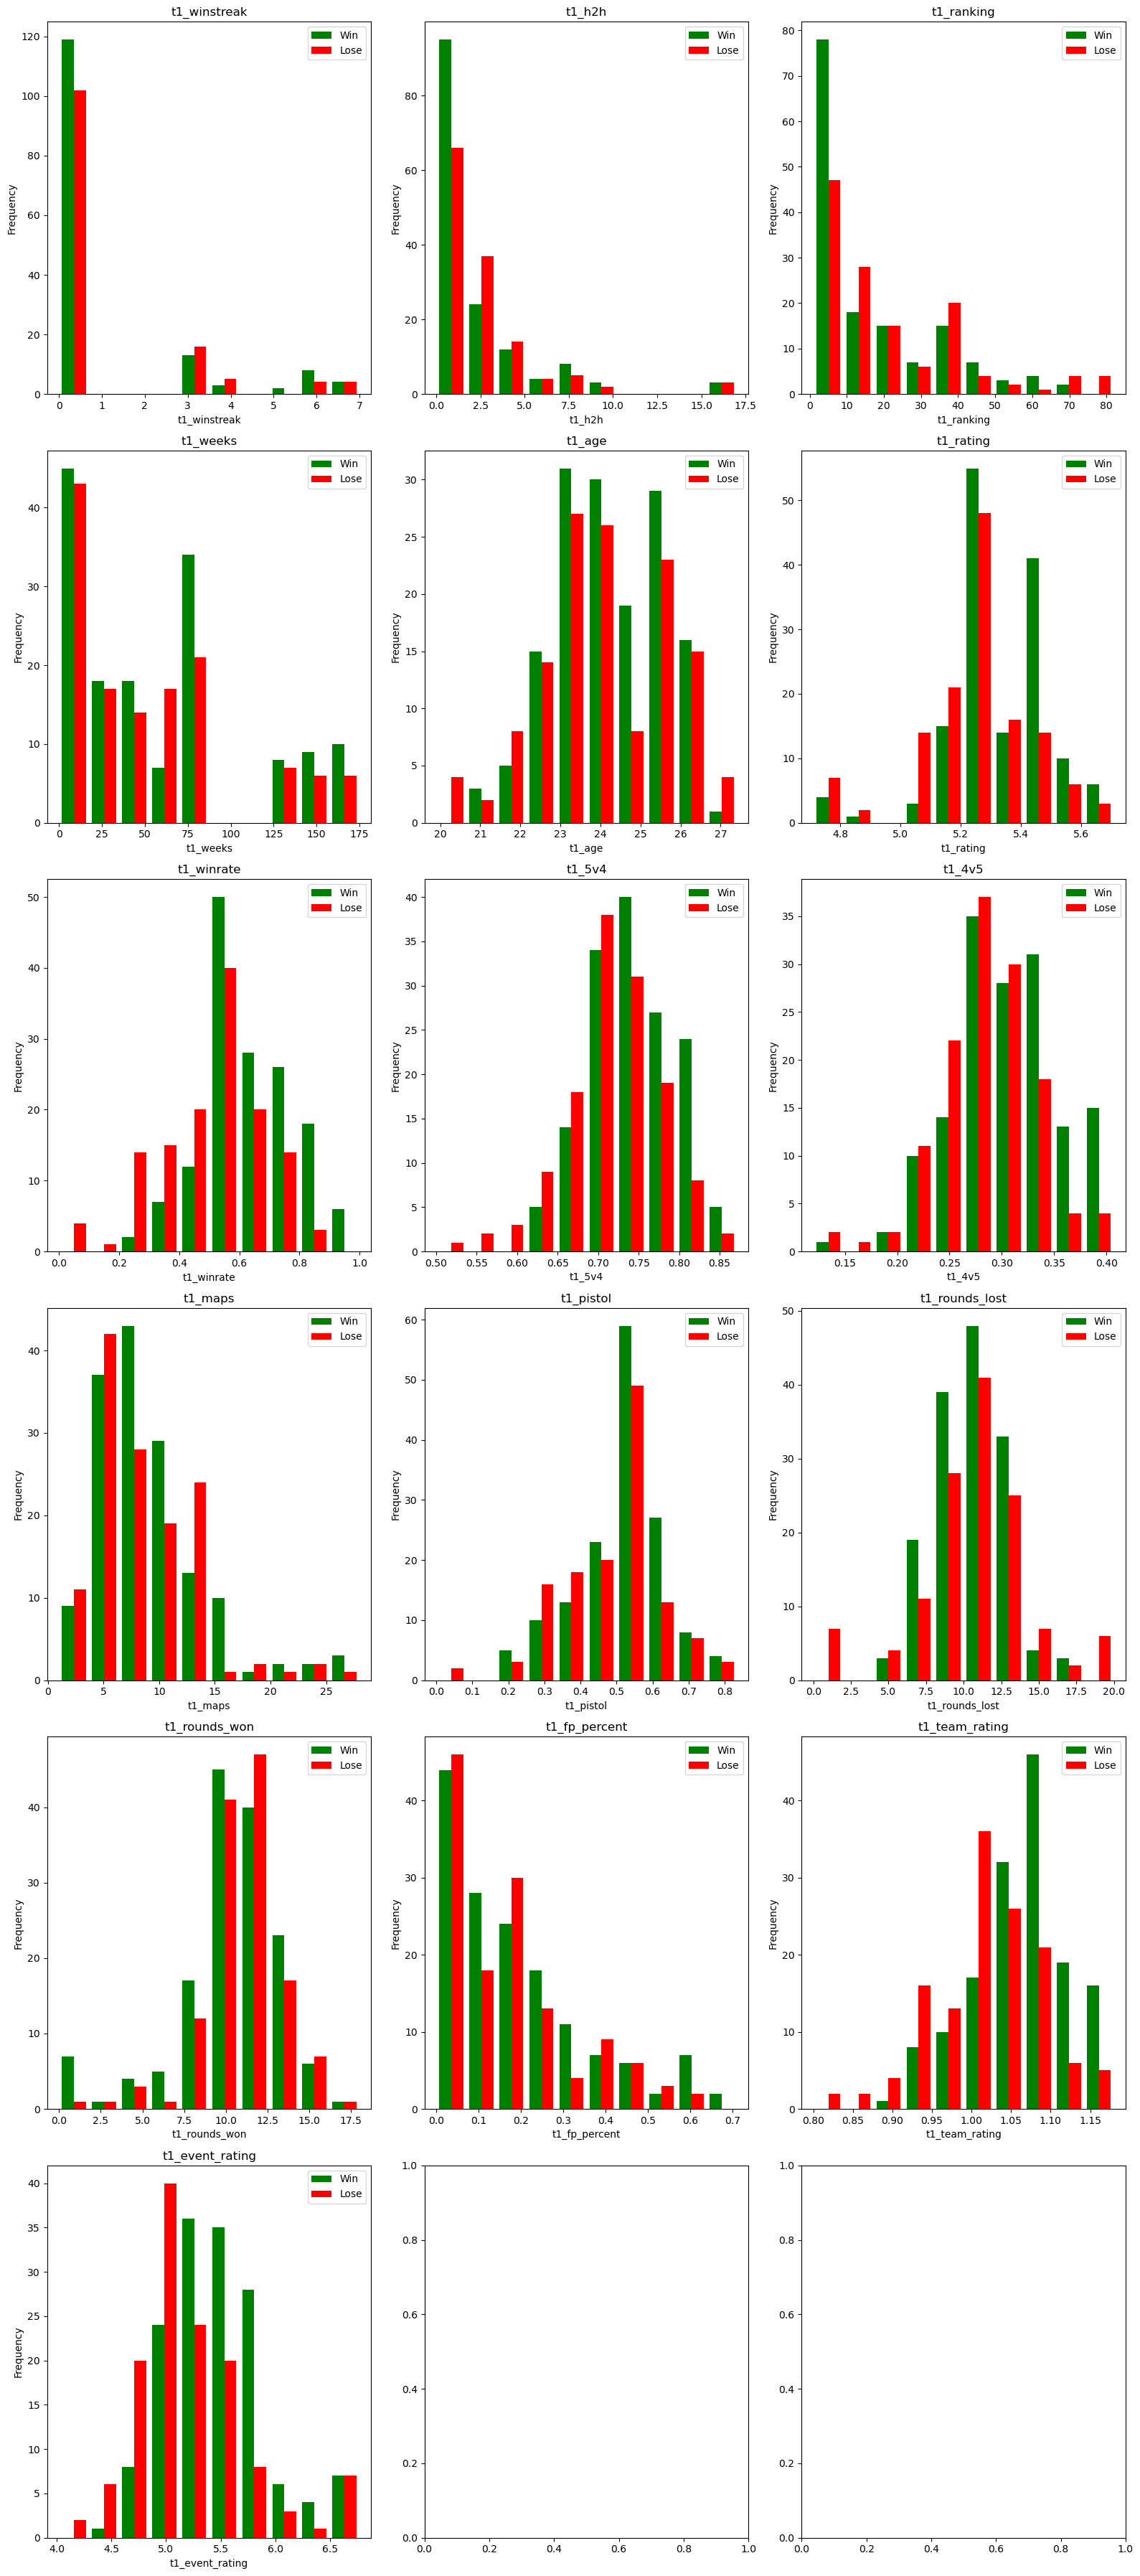

In [8]:
data_columns = [col for col in df.columns if col != 'win' and col != 't1_fp' and col != 't2_fp' and 't1' in col]

num_cols = 3
num_rows = len(data_columns)//num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 6*num_rows))

index = 0
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        if index < len(data_columns):
            axes[row,col].hist(x = [df[df['win']==1][data_columns[index]], df[df['win']==0][data_columns[index]]], 
            stacked=False, color = ['g','r'],label = ['Win','Lose'])
            axes[row,col].set_title(f'{data_columns[index]}')
            axes[row,col].set_xlabel(data_columns[index])
            axes[row,col].set_ylabel('Frequency')
            axes[row,col].legend(['Win', 'Lose'])
            index += 1

plt.tight_layout()
plt.show()

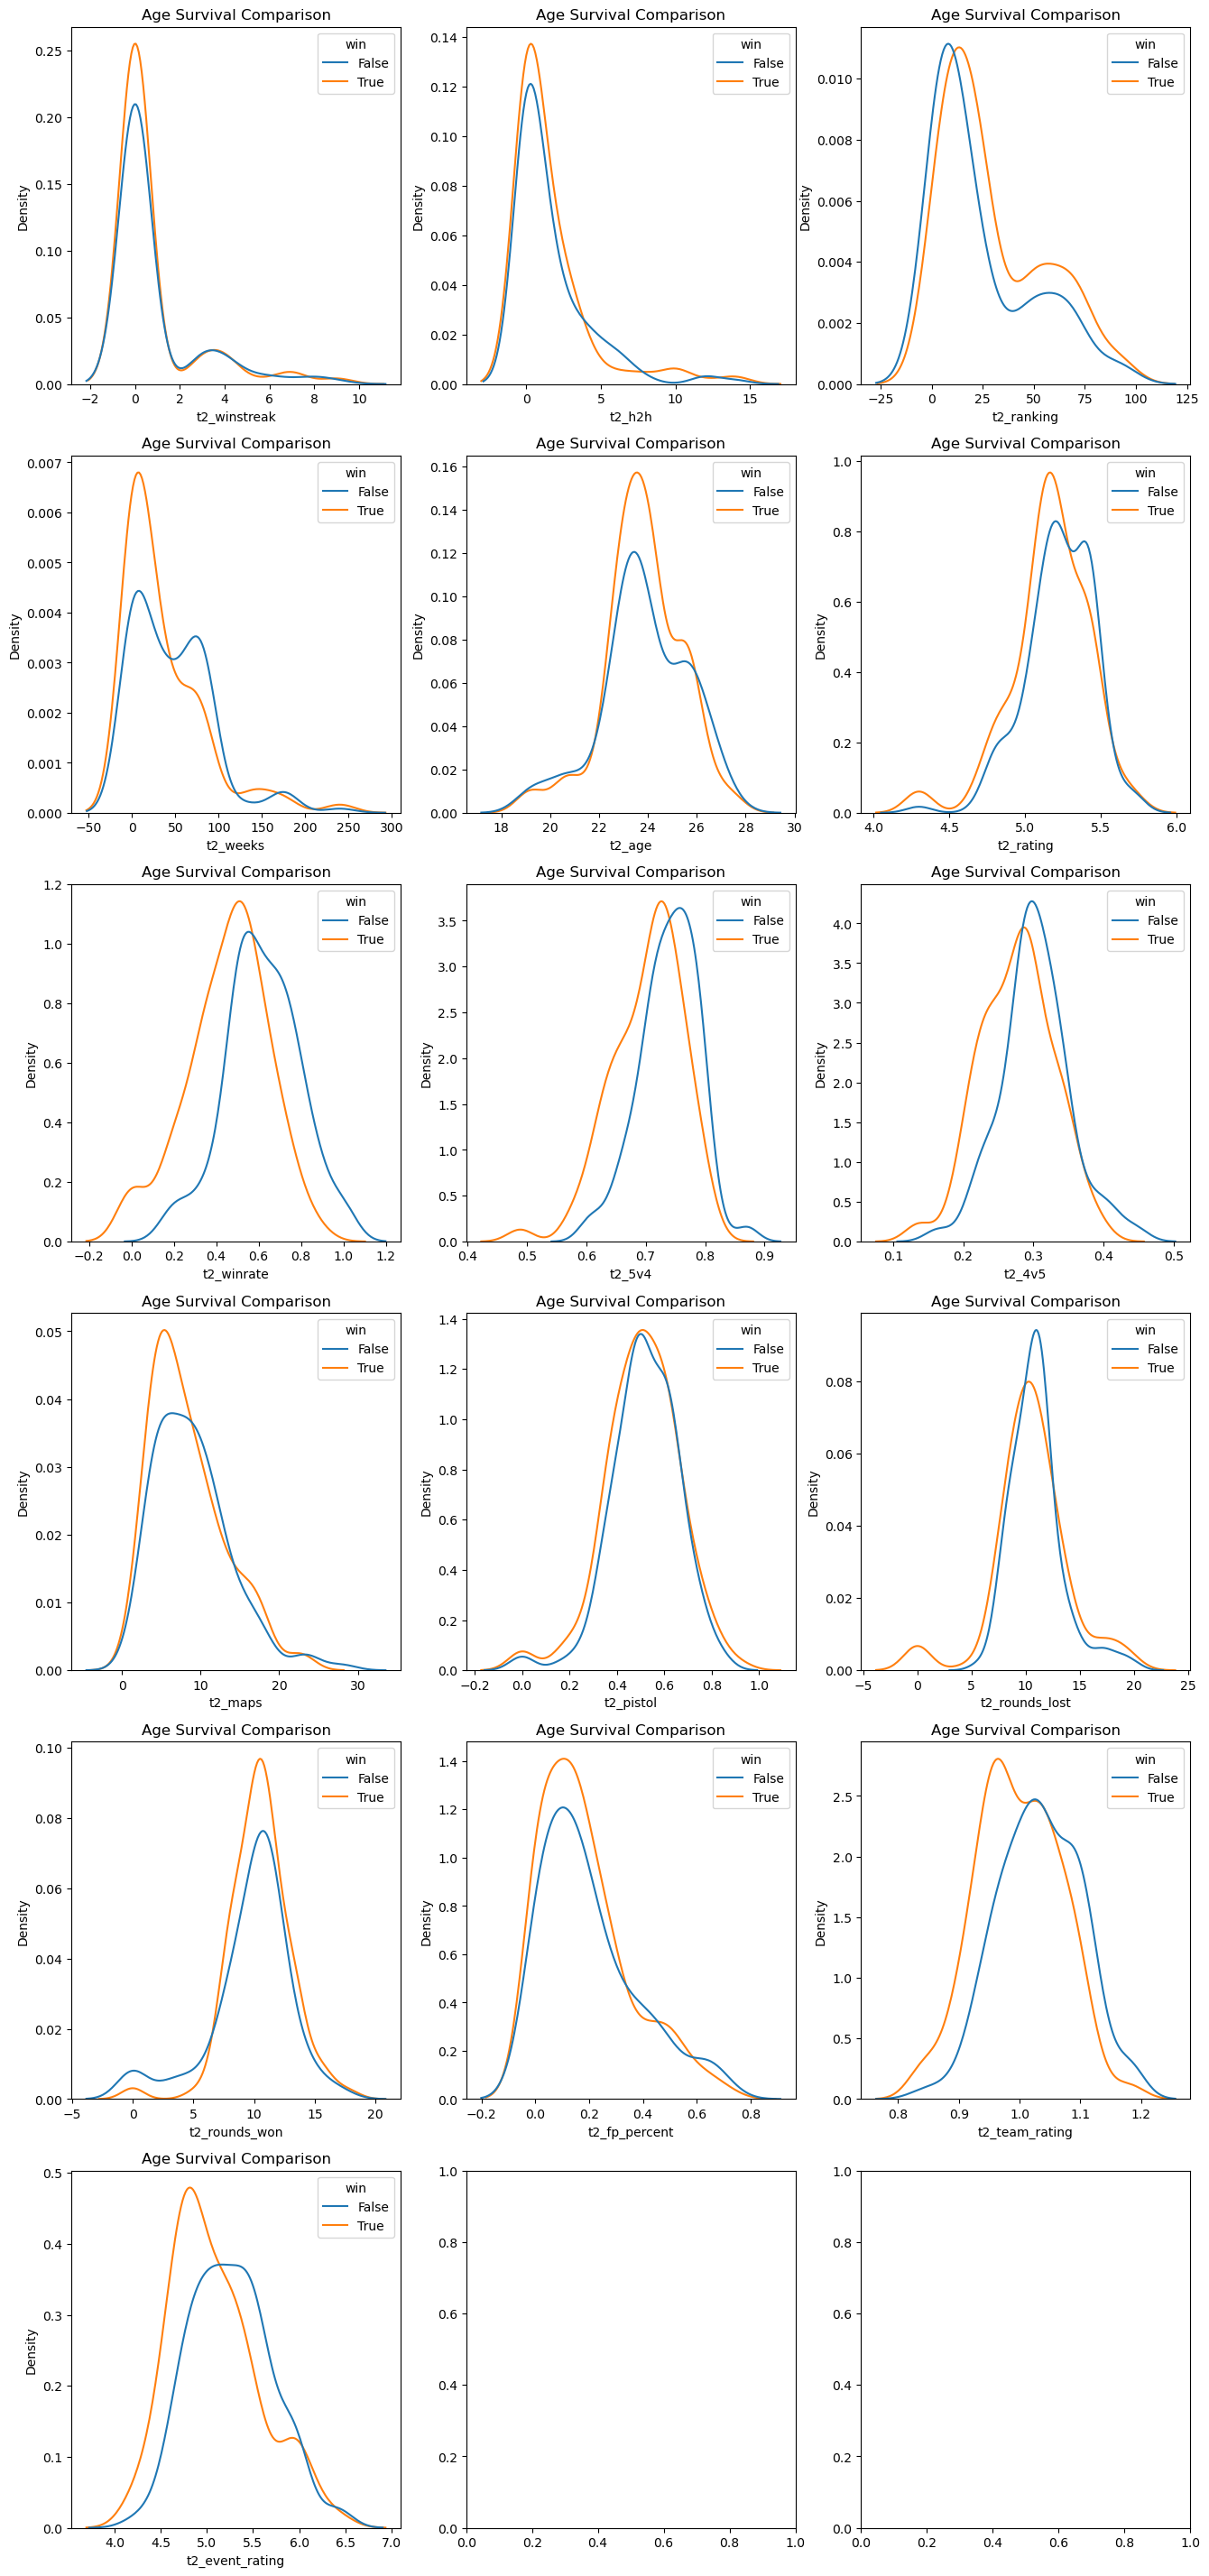

In [9]:
data_columns = [col for col in df.columns if col != 'win' and col != 't1_fp' and col != 't2_fp' and 't2' in col]

num_cols = 3
num_rows = len(data_columns)//num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 6*num_rows))

index = 0
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        if index < len(data_columns):
            sns.kdeplot(x = data_columns[index], hue='win', data = df, ax = axes[row,col])
            axes[row,col].set_title('Age Survival Comparison')
            index += 1

In [ ]:
data_columns = [col for col in df.columns if col != 'win' and col != 't1_fp' and col != 't2_fp']
data_columns[:22]
da = pd.DataFrame()

for index in range(0,22,2):
    da[data_columns[index][3:]] = df.loc[:,data_columns[index]]-df.loc[:,data_columns[index+1]]
for index in range(22,25):
    da[data_columns[index][3:]] = df.loc[:,data_columns[index]]-df.loc[:,data_columns[index+3]]
for index in range(28,30):
    da[data_columns[index][3:]] = df.loc[:,data_columns[index]]-df.loc[:,data_columns[index+2]]
da['win'] = df.loc[:,'win']

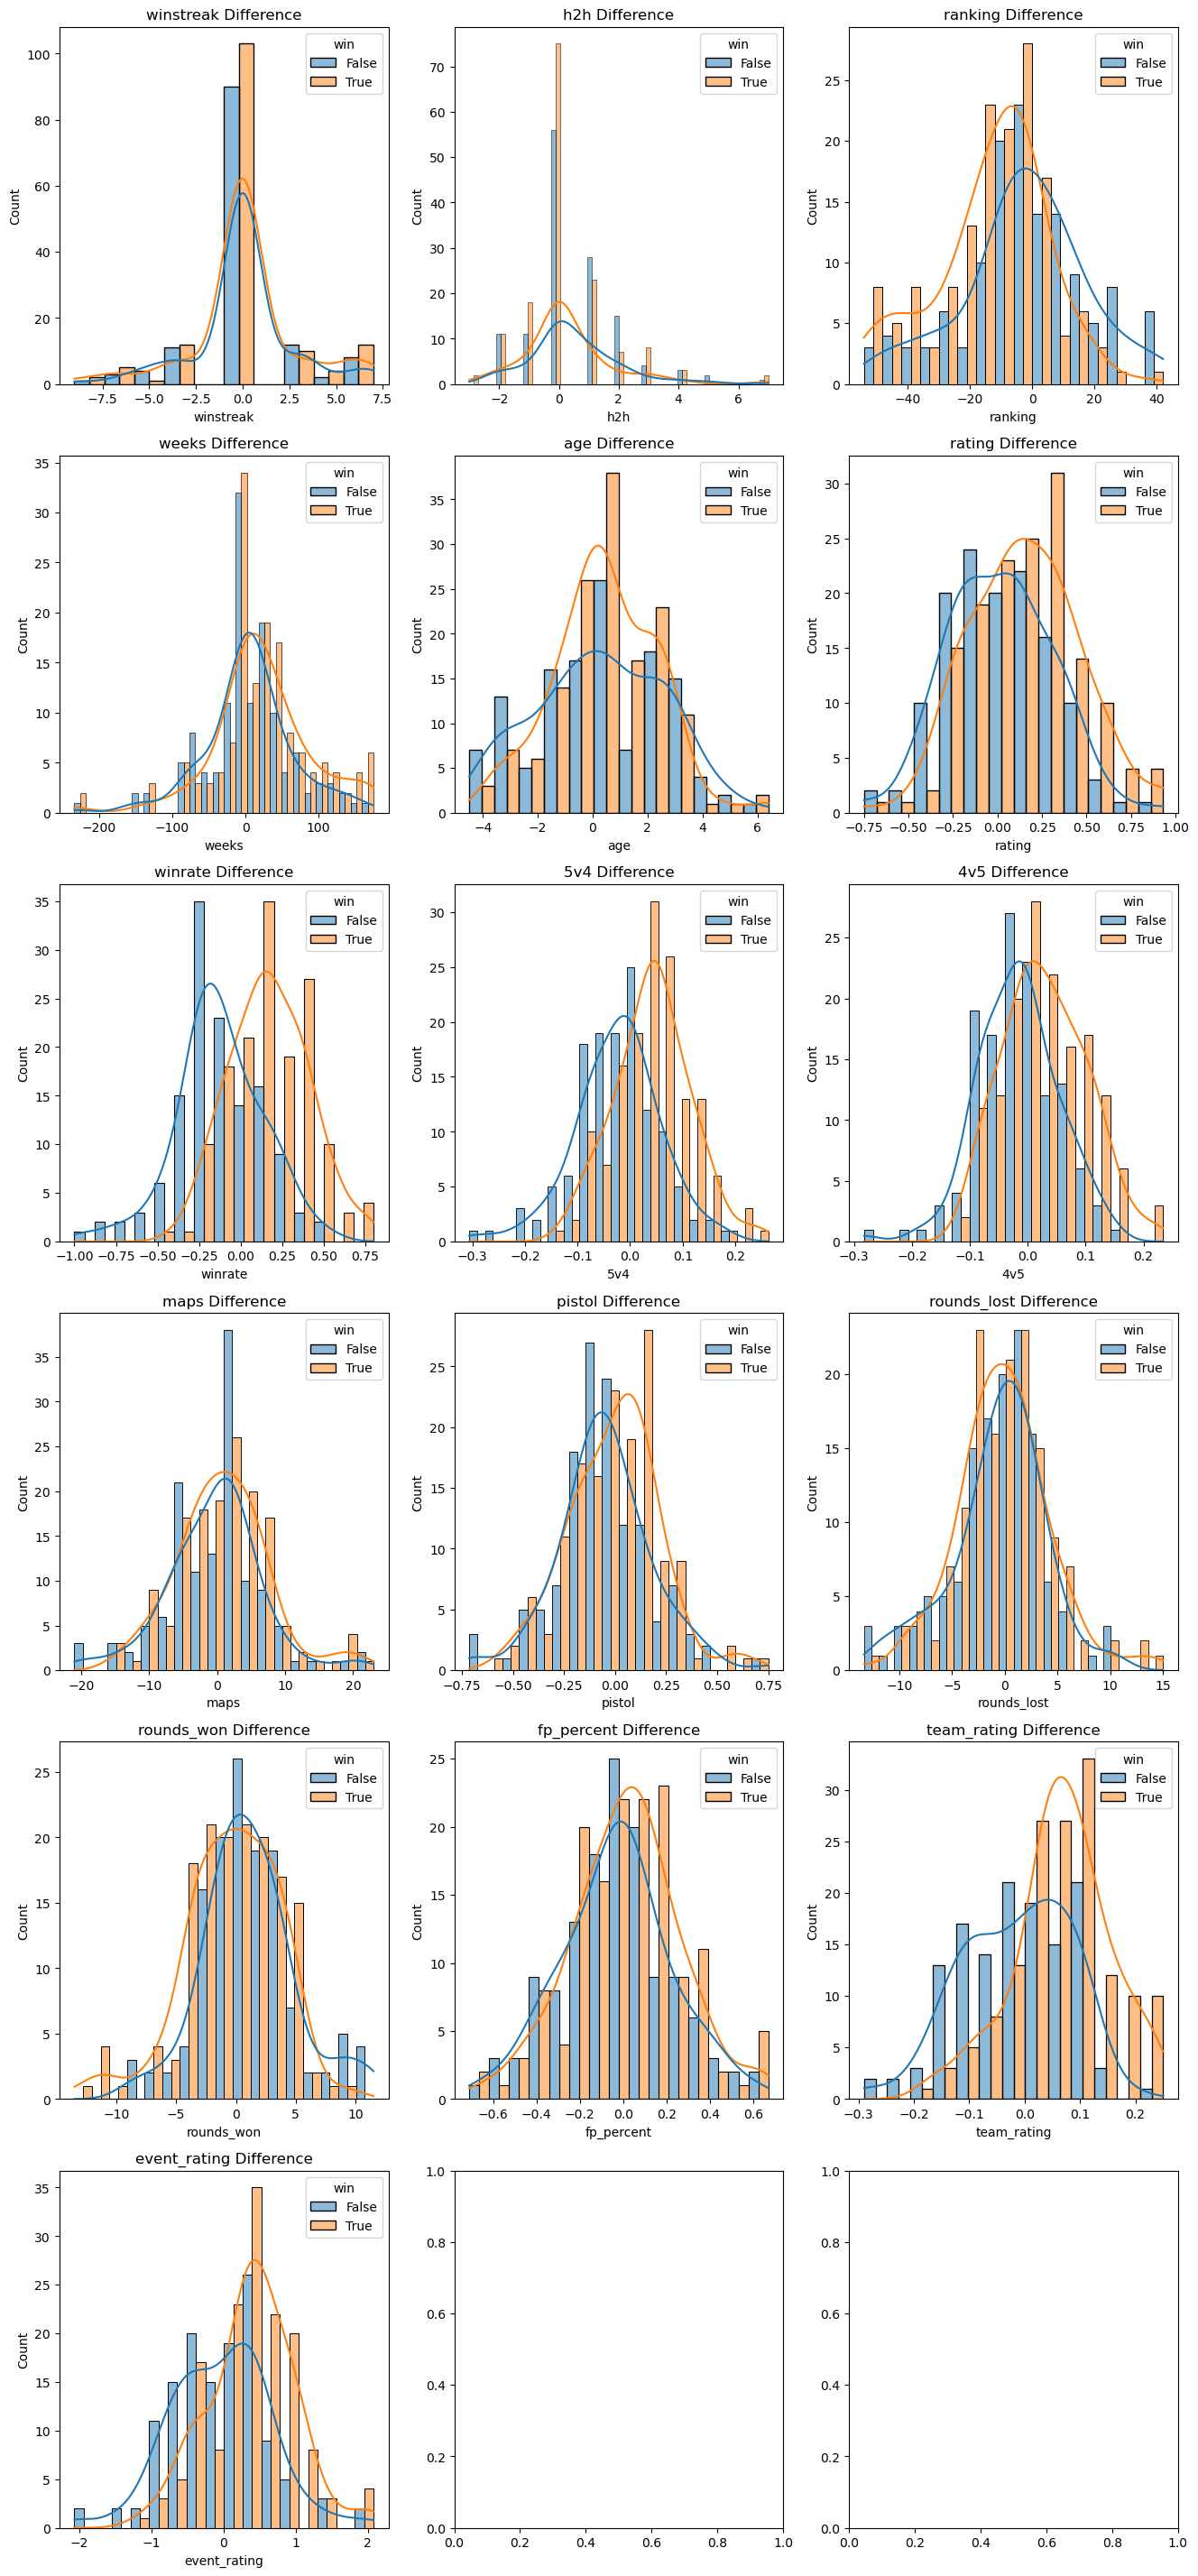

In [11]:
num_cols = 3
num_rows = math.ceil(len(da.columns)/num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 6*num_rows))

index = 0
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        if index < len(da.columns)-1:
            sns.histplot(x = da.columns[index], hue='win', data = da, ax = axes[row,col], kde=True, multiple='dodge')
            axes[row,col].set_title(f'{da.columns[index]} Difference')
            index += 1

In [12]:
print('Correlation by first_pick')
print(df[['t1_fp', 'win']].groupby('t1_fp').mean())
print('---------------')

Correlation by first_pick
            win
t1_fp          
False  0.516129
True   0.587302
---------------


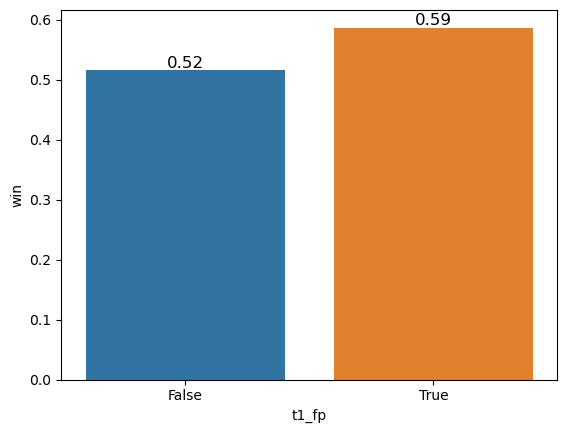

In [13]:
sns.barplot(x='t1_fp', y='win', data=df, errorbar=None)
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

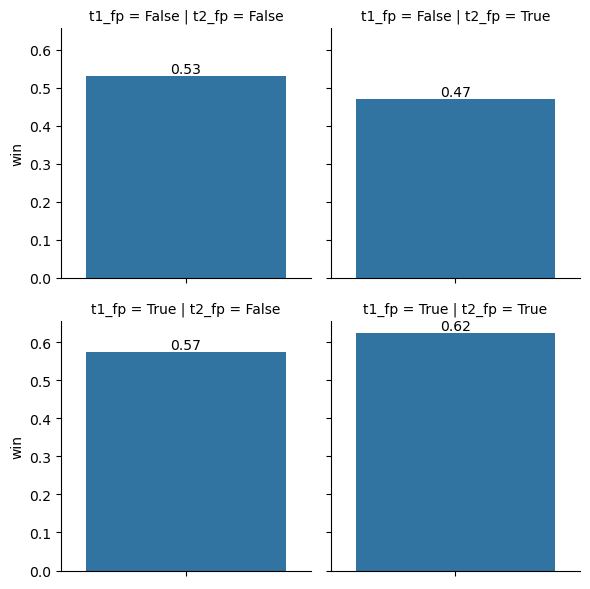

In [14]:
def annotate_bars(*args, **kwargs):
    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

h = sns.FacetGrid(df, col='t2_fp', row='t1_fp')
h.map_dataframe(sns.barplot, y='win', errorbar=None)

h.map(annotate_bars)

### Some Feature Engineering

In [6]:
data_columns = [col for col in df.columns if col != 'win' and col != 't1_fp' and col != 't2_fp']

for index in range(0,22,2):
    df.loc[:,data_columns[index][3:]+'_diff'] = df.loc[:,data_columns[index]]-df.loc[:,data_columns[index+1]]
for index in range(22,25):
    df.loc[:,data_columns[index][3:]+'_diff'] = df.loc[:,data_columns[index]]-df.loc[:,data_columns[index+3]]
for index in range(28,30):
    df.loc[:,data_columns[index][3:]+'_diff'] = df.loc[:,data_columns[index]]-df.loc[:,data_columns[index+2]]

df.head()
    

,t1_winstreak,t2_winstreak,t1_h2h,t2_h2h,t1_ranking,t2_ranking,t1_weeks,t2_weeks,t1_age,t2_age,t1_rating,t2_rating,t1_winrate,t2_winrate,t1_5v4,t2_5v4,t1_4v5,t2_4v5,t1_maps,t2_maps,t1_pistol,t2_pistol,win,t1_rounds_lost,t1_rounds_won,t1_fp,t1_fp_percent,t2_rounds_lost,t2_rounds_won,t2_fp,t2_fp_percent,t1_team_rating,t1_event_rating,t2_team_rating,t2_event_rating,winstreak_diff,h2h_diff,ranking_diff,weeks_diff,age_diff,rating_diff,winrate_diff,5v4_diff,4v5_diff,maps_diff,pistol_diff,rounds_lost_diff,rounds_won_diff,fp_percent_diff,team_rating_diff,event_rating_diff
0,0.0,0.0,0.0,0.0,9.0,4.0,6.0,83.0,24.2,25.7,5.11,5.42,0.600,0.562,0.662,0.756,0.281,0.298,5.0,16.0,0.500,0.656,True,14.00,10.50,False,0.07,8.50,11.33,True,0.61,1.04,5.20,1.03,5.16,0.0,0.0,5.0,-77.0,-1.5,-0.31,0.038,-0.094,-0.017,-11.0,-0.156,5.50,-0.83,-0.54,0.01,0.04
1,0.0,0.0,0.0,0.0,9.0,4.0,6.0,83.0,24.2,25.7,5.11,5.42,0.571,0.500,0.689,0.764,0.264,0.282,7.0,10.0,0.714,0.350,True,11.75,7.33,True,0.29,10.50,11.50,False,0.10,1.04,5.20,1.03,5.16,0.0,0.0,5.0,-77.0,-1.5,-0.31,0.071,-0.075,-0.018,-3.0,0.364,1.25,-4.17,0.19,0.01,0.04
2,0.0,0.0,0.0,1.0,1.0,24.0,85.0,16.0,24.4,23.4,5.49,5.24,0.667,0.333,0.734,0.703,0.293,0.243,9.0,3.0,0.500,0.333,True,13.00,9.33,True,0.24,7.00,9.50,False,0.15,1.16,5.82,0.97,4.85,0.0,-1.0,-23.0,69.0,1.0,0.25,0.334,0.031,0.050,6.0,0.167,6.00,-0.17,0.09,0.19,0.97
3,0.0,0.0,0.0,1.0,1.0,24.0,85.0,16.0,24.4,23.4,5.49,5.24,0.800,0.500,0.803,0.661,0.336,0.220,10.0,4.0,0.500,0.750,True,9.50,9.00,False,0.12,13.00,8.00,False,0.15,1.16,5.82,0.97,4.85,0.0,-1.0,-23.0,69.0,1.0,0.25,0.300,0.142,0.116,6.0,-0.250,-3.50,1.00,-0.03,0.19,0.97
4,0.0,0.0,2.0,1.0,13.0,6.0,54.0,35.0,23.2,23.5,5.06,5.41,0.200,0.615,0.727,0.780,0.205,0.273,5.0,13.0,0.700,0.423,False,9.00,10.00,False,0.16,8.43,10.20,False,0.28,0.99,4.96,1.12,5.61,0.0,1.0,7.0,19.0,-0.3,-0.35,-0.415,-0.053,-0.068,-8.0,0.277,0.57,-0.20,-0.12,-0.13,-0.65


In [ ]:
#Scaling

pipeline = Pipeline([
    ('robust_scaler', StandardScaler()),
    ('min_max_scaler', MinMaxScaler())
])

cols_to_scale = [col for col in df.columns if col != 't1_fp' and col != 't2_fp' and col != 'win']

pipeline.fit(df.loc[:, cols_to_scale])
df.loc[:, cols_to_scale] = pipeline.transform(df.loc[:, cols_to_scale])

with open('cs_pipeline.pkl','wb') as f:
    dump(pipeline, f)

df


In [8]:
df['win'] = df['win'].astype(bool)
df['t1_fp'] = df['t1_fp'].astype(bool)
df['t2_fp'] = df['t2_fp'].astype(bool)

In [10]:
df.describe()

,t1_winstreak,t2_winstreak,t1_h2h,t2_h2h,t1_ranking,t2_ranking,t1_weeks,t2_weeks,t1_age,t2_age,t1_rating,t2_rating,t1_winrate,t2_winrate,t1_5v4,t2_5v4,t1_4v5,t2_4v5,t1_maps,t2_maps,t1_pistol,t2_pistol,t1_rounds_lost,t1_rounds_won,t1_fp_percent,t2_rounds_lost,t2_rounds_won,t2_fp_percent,t1_team_rating,t1_event_rating,t2_team_rating,t2_event_rating,winstreak_diff,h2h_diff,ranking_diff,weeks_diff,age_diff,rating_diff,winrate_diff,5v4_diff,4v5_diff,maps_diff,pistol_diff,rounds_lost_diff,rounds_won_diff,fp_percent_diff,team_rating_diff,event_rating_diff
count,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000
mean,0.112363,0.102973,0.108865,0.104829,0.256129,0.310078,0.279131,0.151573,0.561765,0.541601,0.588592,0.654800,0.558645,0.537076,0.618602,0.612012,0.538318,0.503334,0.320918,0.313406,0.495890,0.560954,0.521146,0.590290,0.266455,0.532068,0.568565,0.276939,0.641438,0.486863,0.536371,0.388003,0.504695,0.398464,0.441881,0.602617,0.470724,0.505968,0.567538,0.549583,0.561125,0.544056,0.475065,0.461924,0.555642,0.491324,0.576630,0.534811
std,0.229628,0.221601,0.176279,0.177189,0.232434,0.265620,0.285212,0.185242,0.214428,0.218403,0.190384,0.175365,0.188794,0.197189,0.147993,0.144408,0.152414,0.160006,0.202412,0.199977,0.127562,0.152638,0.145540,0.161223,0.225909,0.143993,0.160611,0.254815,0.184365,0.187624,0.206689,0.186128,0.153129,0.137336,0.193331,0.150911,0.210453,0.177328,0.160913,0.140290,0.140509,0.149112,0.146640,0.132249,0.154026,0.195206,0.189774,0.170523
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.074074,0.088889,0.034286,0.000000,0.426667,0.426829,0.510000,0.567376,0.444000,0.414500,0.530997,0.536649,0.448485,0.404153,0.185185,0.148148,0.429000,0.477644,0.443000,0.527778,0.084507,0.467250,0.500000,0.059701,0.500000,0.352727,0.382353,0.247059,0.500000,0.363636,0.349057,0.548900,0.312500,0.375723,0.462778,0.463972,0.471954,0.460000,0.387637,0.397188,0.460000,0.358779,0.444444,0.414458
50%,0.000000,0.000000,0.000000,0.000000,0.185185,0.244444,0.200000,0.070833,0.573333,0.524390,0.560000,0.666667,0.571000,0.545000,0.617251,0.628272,0.524242,0.495208,0.296296,0.259259,0.500000,0.545256,0.519000,0.611111,0.211268,0.525000,0.577778,0.223881,0.657895,0.483636,0.558824,0.368627,0.500000,0.363636,0.452830,0.577017,0.464286,0.508671,0.560556,0.548330,0.555126,0.560000,0.486339,0.464062,0.556800,0.496183,0.611111,0.551807
75%,0.000000,0.000000,0.117647,0.142857,0.382716,0.522222,0.474286,0.281250,0.760000,0.756098,0.710000,0.787234,0.698000,0.667000,0.708895,0.714660,0.636364,0.607029,0.407407,0.407407,0.571000,0.654308,0.595750,0.666667,0.366197,0.585500,0.657222,0.410448,0.763158,0.587273,0.705882,0.498039,0.500000,0.454545,0.547170,0.672372,0.642857,0.624277,0.676389,0.634446,0.657640,0.620000,0.568306,0.532031,0.660000,0.610687,0.703704,0.631325
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.

In [9]:
Y_train = df.loc[:,'win']
X_train = df.drop('win', axis=1)

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, random_state=0, train_size=0.85, shuffle=True, stratify=Y_train)

#### Batch testing of common classification algorithms + boosting methods (Found this script somewhere on Kaggle)

In [ ]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
#    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.LogisticRegression(),
#    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Naive Bayes
#    naive_bayes.BernoulliNB(),
#    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
#    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
#    tree.DecisionTreeClassifier(), #RandomForest is better
#    tree.ExtraTreeClassifier(), #ExtraTrees ensemble is better
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier(),
    
    lgb.LGBMClassifier()
    ]


cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .2, train_size = .8, random_state = 0)

#create table to compare MLA metrics
MLA_columns = ['MLA Name','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = Y_train.copy()


#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    
    cv_results = model_selection.cross_validate(alg, x_train, y_train.values.ravel(), cv = cv_split, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #record predictions on the training set to see correlations betweeb model for ensembling
    alg.fit(x_train, y_train.values.ravel())
    MLA_predict[MLA_name] = alg.predict(x_train)
    
    row_index+=1

cb_data = cb.Pool(data=X_train,label=[float(item) for item in Y_train.values])
params = {'eval_metric':'Accuracy',
          'loss_function':'CrossEntropy',
          'verbose':False}
scores = cb.cv(cb_data, fold_count=10, seed=0, shuffle=True, params=params, verbose=False)

MLA_compare.loc[row_index, 'MLA Name'] = 'CatBoost'
MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = scores[['train-Accuracy-mean']].mean()['train-Accuracy-mean']
MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = scores[['test-Accuracy-mean']].mean()['test-Accuracy-mean']
MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = scores[['test-Accuracy-std']].mean()['test-Accuracy-std']

MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

### Fine Tuning (with Optuna)

#### Utility function for testing model accuracy

In [26]:
# For sklearn models
def kfold_check(model, x, y):

    cv = KFold(n_splits=5, shuffle=True)
    acc = 0
    
    for train_index, test_index in cv.split(x,y):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        acc += accuracy_score(y_test, y_pred)
    
    print("Mean Accuracy:", acc/5)

#### LogisticRegression

In [ ]:
def log_objective(trial, X, y):
    param_grid = {
        'C':trial.suggest_float('C', 0.01, 80.0),
        'penalty':trial.suggest_categorical('penalty',['l1', 'l2']),
        'max_iter':trial.suggest_int('max_iter', 100, 3000, step=50),
        'solver':trial.suggest_categorical('solver', ['liblinear'])
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = linear_model.LogisticRegression(**param_grid, random_state=0)
        model.fit(
            X_train,
            y_train,
        )
        preds = model.predict(X_test)
        cv_scores[idx] = accuracy_score(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="maximize", study_name="LogReg Classifier")
func = lambda trial: log_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=200)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")
    
log_model = linear_model.LogisticRegression(random_state=0)
log_model.set_params(**study.best_params)
print('Default Model')
kfold_check(linear_model.LogisticRegression(random_state=0), x_train, y_train.values.ravel())
print('Finetuned')
kfold_check(log_model, x_train, y_train.values.ravel())

#### LinearSVC

In [ ]:
def linSVC_objective(trial, X, y):
    param_grid = {
        'C':trial.suggest_float('C', 0.01, 80.0),
        'dual': trial.suggest_categorical('dual',[False]),
        'max_iter': trial.suggest_int('max_iter', 500, 5000, step=100)
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = svm.LinearSVC(**param_grid, random_state=0)
        model.fit(
            X_train,
            y_train,
        )
        preds = model.predict(X_test)
        cv_scores[idx] = accuracy_score(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="maximize", study_name="SVC Classifier")
func = lambda trial: linSVC_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=200)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")
    
linSVC_model = svm.LinearSVC(random_state=0)
linSVC_model.set_params(**study.best_params)
print("Default Model")
kfold_check(svm.LinearSVC(random_state=0), x_train, y_train.values.ravel())
print("Finetuned")
kfold_check(linSVC_model, x_train, y_train.values.ravel())

#### RidgeClassifier

In [ ]:
def ridge_objective(trial, X, y):
    param_grid = {
        'alpha':trial.suggest_float('alpha', 0.01, 50.0), 
        'solver': trial.suggest_categorical('solver',['svd','cholesky','lsqr','sparse_cg','saga', 'sag'])
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = linear_model.RidgeClassifier(**param_grid, random_state=0)
        model.fit(
            X_train,
            y_train,
        )
        preds = model.predict(X_test)
        cv_scores[idx] = accuracy_score(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="maximize", study_name="Ridge Classifier")
func = lambda trial: ridge_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=200)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")
    
ridge_model = linear_model.RidgeClassifier(random_state=0)
ridge_model.set_params(**study.best_params)
print("Default Model")
kfold_check(linear_model.RidgeClassifier(random_state=0), x_train, y_train.values.ravel())
print("Finetuned")
kfold_check(ridge_model, x_train, y_train.values.ravel())

#### Gaussian Process Classifier

In [ ]:
def gauss_objective(trial, X, y):
    param_grid = {
        'max_iter_predict': trial.suggest_int('max_iter_predict', 100,500),
        'kernel': trial.suggest_categorical('kernel',[ConstantKernel(), DotProduct(), Matern(), RBF(), RationalQuadratic()])
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = gaussian_process.GaussianProcessClassifier(**param_grid, random_state=0, n_jobs=-1)
        model.fit(
            X_train,
            y_train,
        )
        preds = model.predict(X_test)
        cv_scores[idx] = accuracy_score(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="maximize", study_name="Gauss Classifier")
func = lambda trial: gauss_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=200)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")
    
gauss_model = gaussian_process.GaussianProcessClassifier(random_state=0)
gauss_model.set_params(**study.best_params)
print("Default Model")
kfold_check(gaussian_process.GaussianProcessClassifier(random_state=0), x_train, y_train.values.ravel())
print("Finetuned")
kfold_check(gauss_model, x_train, y_train.values.ravel())

#### RandomForest

In [ ]:
def rf_objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "criterion":trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
        "min_samples_leaf":trial.suggest_int("min_samples_leaf", 2, 20),
        "min_samples_split":trial.suggest_int("min_samples_split", 2, 20),
        #"max_features":trial.suggest_categorical("max_features", ['sqrt','log2',None]),
        "max_leaf_nodes":trial.suggest_int("max_leaf_nodes", 20, 350, step=10),
        #"min_impurity_decrease":trial.suggest_float("min_impurity_decrease", 0.0, 0.2, step=0.005),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "max_samples": trial.suggest_float("max_samples", 0.6, 1, step=0.05)
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = ensemble.RandomForestClassifier(**param_grid ,random_state=0, n_jobs=-1)
        model.fit(
            X_train,
            y_train,
        )
        preds = model.predict(X_test)
        cv_scores[idx] = accuracy_score(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="maximize", study_name="RF Classifier")
func = lambda trial: rf_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=100)

print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")
    
rf_model = ensemble.RandomForestClassifier(random_state=0)
rf_model.set_params(**study.best_params)
print("Default Model")
kfold_check(ensemble.RandomForestClassifier(random_state=0), x_train, y_train.values.ravel())
print("Finetuned")
kfold_check(rf_model, x_train, y_train.values.ravel())

#### LDA

In [ ]:
def lda_objective(trial, X, y):
    param_grid = {
        'shrinkage':trial.suggest_float('shrinkage', 0.0, 1.0), 
        'solver': trial.suggest_categorical('solver',['eigen','lsqr'])
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = discriminant_analysis.LinearDiscriminantAnalysis(**param_grid)
        model.fit(
            X_train,
            y_train,
        )
        preds = model.predict(X_test)
        cv_scores[idx] = accuracy_score(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="maximize", study_name="LDA Classifier")
func = lambda trial: lda_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=100)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")
    
lda_model = discriminant_analysis.LinearDiscriminantAnalysis()
lda_model.set_params(**study.best_params)
print("Default Model")
kfold_check(discriminant_analysis.LinearDiscriminantAnalysis(), x_train, y_train.values.ravel())
print("Finetuned")
kfold_check(lda_model, x_train, y_train.values.ravel())

#### CatBoost

In [ ]:
def cb_objective(trial, X, y):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "iterations": trial.suggest_categorical("iterations", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 300, step=1),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 0, 20, step=1),
        "colsample_bylevel": trial.suggest_float(
            "colsample_bylevel", 0.6, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.6, 1, step=0.1),
        "random_strength": trial.suggest_float("random_strength", 0, 1, step=0.1),
        #"grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree"]),
        "bagging_temperature": trial.suggest_float('bagging_temperature', 0, 20, step=0.25)
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = cb.CatBoostClassifier(
                              **param_grid,
                              loss_function='Logloss',
                              random_seed=0,
                              early_stopping_rounds=50,
                              eval_metric='Accuracy'
                              )
 
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )
        preds = [True if item=='True' else False for item in model.predict(X_test)]
        cv_scores[idx] = accuracy_score(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="maximize", study_name="CB Classifier")
func = lambda trial: cb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=100)

print(f"\tBest value : {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

In [ ]:
#### Check accuracies of default and finetuned models
def_model =  cb.CatBoostClassifier(random_seed=0)
cb_model = cb.CatBoostClassifier(
                              loss_function='Logloss',
                              random_seed=0,
                              early_stopping_rounds=50
                              )
 
cb_model.set_params(**study.best_params)

cv = KFold(n_splits=5, shuffle=True)
acc = 0
def_acc = 0

for train_index, test_index in cv.split(x_train,y_train.values.ravel()):
    train_x, test_x = x_train.iloc[train_index], x_train.iloc[test_index]
    train_y, test_y = y_train.values.ravel()[train_index], y_train.values.ravel()[test_index]

    cb_model.fit(
        train_x,
        train_y,
        eval_set=[(test_x, test_y)],
    )
    def_model.fit(train_x, train_y)

    y_pred = [True if item=='True' else False for item in cb_model.predict(test_x)]
    def_pred = [True if item=='True' else False for item in def_model.predict(test_x)]

    acc += accuracy_score(test_y, y_pred)
    def_acc += accuracy_score(test_y, def_pred)
    
print("Finetuned Mean Accuracy:", acc/5)
print("Default Mean Accuracy:", def_acc/5)

#### XGBoost

In [ ]:
def xgb_objective(trial, X, y):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "eta": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 0, 10, step=1),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 20, step=2),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 20, step=2),
        "gamma": trial.suggest_int("gamma", 0, 10, step=1),
        "colsample_bytree": trial.suggest_float(
            "colsample_bytree", 0.6, 1, step=0.1
        ),
        "subsample": trial.suggest_float("subsample", 0.6, 1, step=0.1),
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = XGBClassifier(objective='binary:logistic', **param_grid, seed=0, early_stopping_rounds=50, eval_metric="logloss", verbosity=0, n_jobs=4)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )
        preds = model.predict(X_test)
        cv_scores[idx] = accuracy_score(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="maximize", study_name="XGB Classifier")
func = lambda trial: xgb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=150)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

In [ ]:
xgb_model = XGBClassifier(objective='binary:logistic', seed=0, early_stopping_rounds=50, eval_metric="logloss", verbosity=0)
xgb_model.set_params(**study.best_params)
def_model = XGBClassifier(objective='binary:logistic', seed=0)

cv = KFold(n_splits=5, shuffle=True)
acc = 0
def_acc = 0

for train_index, test_index in cv.split(x_train,y_train.values.ravel()):
    X_train, X_test = x_train.iloc[train_index], x_train.iloc[test_index]
    Y_train, Y_test = y_train.values.ravel()[train_index], y_train.values.ravel()[test_index]

    xgb_model.fit(
        X_train,
        Y_train,
        eval_set=[(X_test, Y_test)],
    )
    def_model.fit(
        X_train,
        Y_train
    )

    y_pred = xgb_model.predict(X_test)
    def_pred = def_model.predict(X_test)

    acc += accuracy_score(Y_test, y_pred)
    def_acc += accuracy_score(Y_test, def_pred)
    
print("Finetuned Mean Accuracy:", acc/5)
print("Default Mean Accuracy:", def_acc/5)

#### LightGBM

In [ ]:
def lgb_objective(trial, X, y):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 20),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 20),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.6, 1, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.6, 1, step=0.1
        ),
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgb.LGBMClassifier(objective="binary", **param_grid, random_state=0, verbosity=-1, early_stopping_rounds=50)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            verbose=False
#            callbacks=[
#                LightGBMPruningCallback(trial, "binary_logloss")
#            ],  # Add a pruning callback
        )
        preds = model.predict(X_test)
        cv_scores[idx] = accuracy_score(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: lgb_objective(trial, x_train, np.ravel(y_train.values))
study.optimize(func, n_trials=150)

print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

In [ ]:
lgb_model = lgb.LGBMClassifier(objective="binary", random_state=0, verbosity=-1, early_stopping_rounds=50)
lgb_model.set_params(**study.best_params)
def_model = lgb.LGBMClassifier(objective="binary", random_state=0, verbosity=-1)

cv = KFold(n_splits=5, shuffle=True)
acc = 0
def_acc = 0

for train_index, test_index in cv.split(x_train,y_train.values.ravel()):
    X_train, X_test = x_train.iloc[train_index], x_train.iloc[test_index]
    Y_train, Y_test = y_train.values.ravel()[train_index], y_train.values.ravel()[test_index]

    lgb_model.fit(
        X_train,
        Y_train,
        eval_set=[(X_test, Y_test)],
    )
    def_model.fit(
        X_train,
        Y_train
    )

    y_pred = lgb_model.predict(X_test)
    def_pred = def_model.predict(X_test)

    acc += accuracy_score(Y_test, y_pred)
    def_acc += accuracy_score(Y_test, def_pred)
    
print("Finetuned Mean Accuracy:", acc/5)
print("Default Mean Accuracy:", def_acc/5)

In [ ]:
lgb_model = lgb.LGBMClassifier(
    	random_state=0,
        objective='binary',
        n_estimators=62,
		learning_rate=0.03575147073215729,
		num_leaves=1760,
		max_depth=4,
		min_data_in_leaf=28,
		lambda_l1=0,
		lambda_l2=12,
		min_gain_to_split=3.749402223601987,
		bagging_fraction=1.0,
		bagging_freq=1,
		feature_fraction=0.8
)
def_model = lgb.LGBMClassifier(objective='binary',random_state=0)

lgb_model.fit(
      x_train,
      y_train
)
def_model.fit(
      x_train,
      y_train
)

preds = lgb_model.predict(x_test)
def_preds = def_model.predict(x_test)

print(f"Finetuned: {accuracy_score(y_test, preds)}")
print(f"Default: {accuracy_score(y_test, def_preds)}")

### After fine-tuning, I started evaluating all models on test set and realized that it is not representative accuracy since the test set is small. So, I fine-tuned all models again but on the whole dataset with cross-validation and decided to go with best-performing parameters.

### Fitting models with best parameters on whole dataset and save for inference

In [43]:
log_model = linear_model.LogisticRegression(random_state=0, C=1.400839883254968, penalty='l1', max_iter=1400, solver='liblinear')
log_model.fit(X_train, Y_train.values.ravel())

with open("models/logReg.pkl", "wb") as file:
    dump(log_model, file)

In [45]:
linSVC_model = svm.LinearSVC(random_state=0, C=0.015290908734060749, dual=False, max_iter=3600)
linSVC_model.fit(X_train, Y_train.values.ravel())

with open("models/linSVC.pkl", "wb") as file:
    dump(linSVC_model, file)

In [46]:
ridge_model = linear_model.RidgeClassifier(random_state=0, alpha=27.22220374770965, solver='lsqr')
ridge_model.fit(X_train, Y_train.values.ravel())

with open("models/ridge.pkl", "wb") as file:
    dump(ridge_model, file)

In [47]:
gauss_model = gaussian_process.GaussianProcessClassifier(random_state=0, max_iter_predict=387, kernel=DotProduct(sigma_0=1))
gauss_model.fit(X_train, Y_train.values.ravel())

with open("models/gauss.pkl", "wb") as file:
    dump(gauss_model, file)

In [48]:
rf_model = ensemble.RandomForestClassifier(random_state=0, n_estimators=450, criterion='entropy', min_samples_leaf=15, min_samples_split=3, max_leaf_nodes=140, max_depth=8, max_samples=0.7)
rf_model.fit(X_train, Y_train.values.ravel())

with open("models/rf.pkl", "wb") as file:
    dump(rf_model, file)

In [49]:
lda_model = discriminant_analysis.LinearDiscriminantAnalysis(shrinkage=0.7262065497529062, solver='lsqr')
lda_model.fit(X_train, Y_train.values.ravel())

with open("models/LDA.pkl", "wb") as file:
    dump(lda_model, file)

In [ ]:
cb_model = cb.CatBoostClassifier(random_seed=0, iterations=10000, learning_rate=0.05158589236699565, max_depth=3, l2_leaf_reg=6, colsample_bylevel=0.8, subsample=0.6, 
                                 random_strength=0.9, bagging_temperature=0.5, loss_function='Logloss', early_stopping_rounds=50, eval_metric='Accuracy')

cv = KFold(n_splits=5, shuffle=True)
best_iteration = 0

for train_index, test_index in cv.split(X_train,Y_train.values.ravel()):
    # Split the data into training and testing sets for this fold
    train_x, test_x = X_train.iloc[train_index], X_train.iloc[test_index]
    train_y, test_y = Y_train.values.ravel()[train_index], Y_train.values.ravel()[test_index]

    # Train a model on the training data
    cb_model.fit(
        train_x,
        train_y,
        eval_set=[(test_x, test_y)],
    )

    best_iteration += cb_model.get_best_iteration()

best_iteration /= 5    
print("Mean Best Iteration:", best_iteration)

cb_model = cb.CatBoostClassifier(random_seed=0, iterations=round(best_iteration), learning_rate=0.05158589236699565, max_depth=3, l2_leaf_reg=6, colsample_bylevel=0.8, subsample=0.6, 
                                 random_strength=0.9, bagging_temperature=0.5, loss_function='Logloss')
cb_model.fit(X_train, Y_train)

with open("models/cb.pkl", "wb") as file:
    dump(cb_model, file)

In [ ]:
xgb_model = XGBClassifier(objective='binary:logistic', seed=0, early_stopping_rounds=50, eval_metric="error", verbosity=0, n_jobs=4,
                          n_estimators=10000, learning_rate=0.16303311381451563, max_depth=6, min_child_weight=7, reg_lambda=4, reg_alpha=0,
                          gamma=2, colsample_bytree=0.6, subsample=0.9)

cv = KFold(n_splits=5, shuffle=True)
best_iteration = 0

for train_index, test_index in cv.split(X_train,Y_train.values.ravel()):
    train_x, test_x = X_train.iloc[train_index], X_train.iloc[test_index]
    train_y, test_y = Y_train.values.ravel()[train_index], Y_train.values.ravel()[test_index]

    xgb_model.fit(
        train_x,
        train_y,
        eval_set=[(test_x, test_y)],
    )

    best_iteration += xgb_model.best_iteration

best_iteration /= 5    
print("Mean Best Iteration:", best_iteration)

xgb_model = XGBClassifier(objective='binary:logistic', seed=0, verbosity=0, n_jobs=4,
                          n_estimators=round(best_iteration), learning_rate=0.16303311381451563, max_depth=6, min_child_weight=7, reg_lambda=4, reg_alpha=0,
                          gamma=2, colsample_bytree=0.6, subsample=0.9)
xgb_model.fit(X_train, Y_train)

with open("models/xgb.pkl", "wb") as file:
    dump(xgb_model, file)

In [ ]:
lgb_model = lgb.LGBMClassifier(objective="binary", random_state=0, verbosity=-1, early_stopping_rounds=50, metric='average_precision',
                               n_estimators=10000, learning_rate=0.2221094900469117, num_leaves=20, max_depth=7, min_data_in_leaf=29,
                               lambda_l1=0, lambda_l2=6, min_gain_to_split=8.542001290263649, bagging_fraction=0.8, bagging_freq=1,
                               feature_fraction=1.0)

cv = KFold(n_splits=5, shuffle=True)
best_iteration = 0

for train_index, test_index in cv.split(X_train,Y_train.values.ravel()):
    train_x, test_x = X_train.iloc[train_index], X_train.iloc[test_index]
    train_y, test_y = Y_train.values.ravel()[train_index], Y_train.values.ravel()[test_index]

    lgb_model.fit(
        train_x,
        train_y,
        eval_set=[(test_x, test_y)],
        verbose=False
    )

    best_iteration += lgb_model.best_iteration_

best_iteration /= 5    
print("Mean Best Iteration:", best_iteration)

lgb_model = lgb.LGBMClassifier(objective="binary", random_state=0, verbosity=-1, n_estimators=round(best_iteration), learning_rate=0.2221094900469117, 
                               num_leaves=20, max_depth=7, min_data_in_leaf=29, lambda_l1=0, lambda_l2=6, min_gain_to_split=8.542001290263649, 
                               bagging_fraction=0.8, bagging_freq=1, feature_fraction=1.0)
lgb_model.fit(X_train, Y_train)

with open("models/lgb.pkl", "wb") as file:
    dump(lgb_model, file)

### Feature Importance analysis with SHAP package

#### XGBoost Features

In [15]:
Y = df.loc[:,'win']
X = df.drop('win', axis=1)

In [ ]:
with open("models/lgb.pkl", "rb") as file:
    xgb_model = load(file)

importance = xgb_model.feature_importances_

feature_names = X.columns  
feature_importance = list(zip(feature_names, importance))
feature_importance.sort(key=lambda x: x[1], reverse=True)

for feature, importance in feature_importance:
    print(f"{feature}: {importance}")

In [ ]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(xgb_model, X, Y, n_repeats=30, random_state=0)

for i in perm_importance.importances_mean.argsort()[::-1]:
    print(f"{X.columns[i]}: {perm_importance.importances_mean[i]}")

In [ ]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

#### LGBM Features

In [ ]:
with open("models/lgb.pkl", "rb") as file:
    lgb_model = load(file)

lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=20)
plt.show()

In [ ]:
importance = lgb_model.feature_importances_

feature_names = X.columns 
feature_importance = list(zip(feature_names, importance))
feature_importance.sort(key=lambda x: x[1], reverse=True)

for feature, importance in feature_importance:
    print(f"{feature}: {importance}")

#### CatBoost Features

In [ ]:
with open("models/cb.pkl", "rb") as file:
    cb_model = load(file)

cb_model.get_feature_importance(prettified=True).plot(kind='bar', x='Feature Id', y='Importances', title='Feature Importance', figsize=(10, 6))
plt.show()

#### Logistic Regression Features

In [ ]:
with open("models/logReg.pkl", "rb") as file:
    lr_model = load(file)

coefficients = lr_model.coef_[0]

feature_names = X.columns
feature_importance = list(zip(feature_names, abs(coefficients)))
feature_importance.sort(key=lambda x: x[1], reverse=True)

for feature, importance in feature_importance:
    print(f"{feature}: {importance}")

In [ ]:
from sklearn.feature_selection import RFE

selector = RFE(lr_model, n_features_to_select=1)

selector = selector.fit(X, Y)
ranking = selector.ranking_

feature_names = X.columns  
feature_ranking = list(zip(feature_names, ranking))
feature_ranking.sort(key=lambda x: x[1])

for feature, rank in feature_ranking:
    print(f"{feature}: Rank {rank}")

#### LDA Features

In [ ]:
with open("models/LDA.pkl", "rb") as file:
    lda_model = load(file)

selector = RFE(lda_model, n_features_to_select=1)

selector = selector.fit(X, Y)
ranking = selector.ranking_

feature_names = X.columns
feature_ranking = list(zip(feature_names, ranking))
feature_ranking.sort(key=lambda x: x[1])

for feature, rank in feature_ranking:
    print(f"{feature}: Rank {rank}")